### Compare different weighting schemes for emission average at unique time-steps to determine spatial correlation characteristics  

- city-center distance weight: monitoring sites with a similar distance to the city center are weighted higher
- inverse distance weighting (IDW): near-by locations are weighted higher 
- no spatial weighting: average of all stations at same time step   

In [1]:
# load data
import geopandas as gpd
import pandas as pd

# read sites and adjust naming
sites = gpd.read_file('../data/monitoring_station/monitoring_station.shp')[['id', 'geometry']]
sites['id'] = sites['id'].apply(lambda x : x.lower().replace(' ', '')[:5])
sites = sites[(sites['id']!='mc014')&(sites['id']!='mc085')]

# read dataframe with target variable and predictor features for all timesteps
main = pd.read_csv('../datasets/df_2023_imputed.csv')[['time_step', 'id',	'NO2']]
main.head(5)

ModuleNotFoundError: No module named 'geopandas'

### spatial similarity estimation

In [8]:
# city-center distance weight (CCDW)
from sklearn.feature_selection import mutual_info_regression
from shapely.geometry import Point
import numpy as np
import math

# 1. add distance to Fehrnsehturm as distance to berlin center

def return_distance_center(point, latitude = 52.520803, longitude = 13.40945):
    '''
    return distance in meter between point (geometry) and 
    second point specified by lat and long (EPSG:4326)
    '''
    center_point = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[Point(longitude, latitude)])
    center_point = center_point.to_crs('EPSG:25833')
    center_geometry = center_point.geometry[0]
    return center_geometry.distance(point)

sites['distance_city'] = sites['geometry'].apply(lambda x: return_distance_center(point =x)/1000) # in meter 

#merge with previous file
main = pd.merge(main, sites, on = 'id', how= 'outer').drop(['geometry'], axis= 1)

# 2. calculate weighted mean pollution based on similarity in distance to the city center

def cc_weighted_mean(row):
    # Filter for other stations at the same timestamp
    same_time = main[main['time_step'] == row['time_step']]
    # Exclude the current station's measurement
    other_stations = same_time[same_time['id'] != row['id']]
    
    if other_stations.empty:
        return np.nan  # Return NaN if no other stations are available at the same time
    
    # Calculate similarity weights based on the inverse of the absolute difference in distances
    weights = 1 / (1 + np.abs(other_stations['distance_city'] - row['distance_city']))
       
    # Calculate the weighted mean pollution
    weighted_mean = np.average(other_stations['NO2'], weights=weights)
    return weighted_mean

# Apply the function to each row to calculate the new feature
main['cc_weighted_mean_pollution'] = main.apply(cc_weighted_mean, axis=1)

# 3. return correlate
correlation, p_value = main['NO2'].corr(main['cc_weighted_mean_pollution'], method='pearson'), None
print(f"Pearson correlation for city center weighted average: {correlation}")

# 4. return mutual information
mi_score = mutual_info_regression(main.filter(['NO2']), main['cc_weighted_mean_pollution'])
print(f"Mutual Information for city center weighted average: {mi_score}.")



Pearson correlation for city center weighted average: 0.717581091107383
Mutual Information for city center weighted average: [0.35371728].


In [10]:
# city-center (sqrt difference) distance weight (CCDW)
from sklearn.feature_selection import mutual_info_regression
from shapely.geometry import Point
import numpy as np

# 1. calculate weighted mean pollution based on similarity in distance to the city center

def cc_weighted_mean(row):
    # Filter for other stations at the same timestamp
    same_time = main[main['time_step'] == row['time_step']]
    # Exclude the current station's measurement
    other_stations = same_time[same_time['id'] != row['id']]
    
    if other_stations.empty:
        return np.nan  # Return NaN if no other stations are available at the same time
    
    # Calculate similarity weights based on the inverse of the absolute difference in distances
    weights = 1 / ((np.abs(other_stations['distance_city'] - row['distance_city']))**(1/4))
    
    # Calculate the weighted mean pollution
    weighted_mean = np.average(other_stations['NO2'], weights=weights)
    return weighted_mean

# Apply the function to each row to calculate the new feature
main['cc_sqrt_weighted_mean_pollution'] = main.apply(cc_weighted_mean, axis=1)

# 3. return correlate
correlation, p_value = main['NO2'].corr(main['cc_sqrt_weighted_mean_pollution'], method='pearson'), None
print(f"Pearson correlation for sqrt city center weighted average: {correlation}")

# 4. return mutual information
mi_score = mutual_info_regression(main.filter(['NO2']), main['cc_sqrt_weighted_mean_pollution'])
print(f"Mutual Information for sqrt city center weighted average: {mi_score}.")


Pearson correlation for sqrt city center weighted average: 0.6654973088619369
Mutual Information for sqrt city center weighted average: [0.27772331].


In [18]:
# inverse distance weighting (IDW)
import numpy as np
# 1. calculate distance between all station
def calculate_distance_matrix(sites):
    """Calculate the pairwise distance matrix for sites."""

    site_points = sites['geometry']
    num_sites = len(site_points)
    dist_matrix = np.zeros((num_sites, num_sites))

    for i in range(num_sites):
        for j in range(num_sites):
            # Calculate distance between points
            dist_matrix[i, j] = site_points[i].distance(site_points[j]) / 1000 # convert to km

    dist_matrix = pd.DataFrame(dist_matrix, index= sites['id'], columns= sites['id'])
    return dist_matrix

dist_matrix = calculate_distance_matrix(sites= sites.reset_index())

# 2. calculate inverse distance weighted average of pollution

def inverse_distance_weighting(row, main, dist_matrix):
    # filter for correct date
    same_time = main[main['time_step'] == row['time_step']]
    # Exclude the current station's measurement
    other_stations = same_time[same_time['id'] != row['id']].sort_values('id')

    # Get distances and sort to ensure order matches
    distances = dist_matrix.loc[row['id'], other_stations['id']]
    
    # inverse distance + normalization    
    inverse_distances = 1 / distances
    inverse_distances = inverse_distances/ inverse_distances.sum()
    
    # Calculate the weighted mean pollution, ensuring the order matches
    weighted_mean = np.average(
        other_stations['NO2'],
        weights=inverse_distances
    )
    
    return weighted_mean

# Calculate the inverse distance mean
main['inverse_distance_pollution'] = main.apply(
    lambda row: inverse_distance_weighting(row, main, dist_matrix),
    axis=1
)

# 3. return correlation
correlation = main['NO2'].corr(main['inverse_distance_pollution'], method='pearson')
print(f"Pearson correlation for inverse distance average: {correlation}")

# 4. return mutual information
mi_score = mutual_info_regression(main.filter(['NO2']), main['inverse_distance_pollution'])
print(f"Mutual Information for inverse distance average: {mi_score}.")



Pearson correlation for inverse distance average: 0.648084059409781
Mutual Information for inverse distance average: [0.25721471].


In [19]:
# non- weighted average

def non_weighted_average(row, main):
    # filter for correct date
    same_time = main[main['time_step'] == row['time_step']]
    # Exclude the current station's measurement
    other_stations = same_time[same_time['id'] != row['id']].sort_values('id')

    weighted_mean = np.average(other_stations['NO2'])
    
    return weighted_mean

# Calculate the inverse distance mean
main['non_weighted_mean_pollution'] = main.apply(lambda row: non_weighted_average(row, main), axis=1)

# Correlation
correlation = main['NO2'].corr(main['non_weighted_mean_pollution'], method='pearson')
print(f"Pearson correlation for non-weighted average in pollution: {correlation}")

# 4. return mutual information
mi_score = mutual_info_regression(main.filter(['NO2']), main['non_weighted_mean_pollution'])
print(f"Mutual Information for non- weighted average: {mi_score}.")



Pearson correlation for non-weighted average in pollution: 0.623769773853018
Mutual Information for non- weighted average: [0.29397268].


### feature importance

In [15]:
main = pd.read_csv('data/datasets/df_processed.csv')

def cc_weighted_mean(row):
    # Filter for other stations at the same timestamp
    same_time = main[main['time_step'] == row['time_step']]
    # Exclude the current station's measurement
    other_stations = same_time[same_time['id'] != row['id']]
    
    if other_stations.empty:
        return np.nan  # Return NaN if no other stations are available at the same time
    
    # Calculate similarity weights based on the inverse of the absolute difference in distances
    weights = 1 / (1 + np.abs(other_stations['distance_city'] - row['distance_city']))
       
    # Calculate the weighted mean pollution
    weighted_mean = np.average(other_stations['NO2'], weights=weights)
    return weighted_mean

# Apply the function to each row to calculate the new feature
main['weighted_mean_pollution'] = main.apply(cc_weighted_mean, axis=1)

In [20]:
# read data
import pandas as pd
from sklearn.feature_selection import mutual_info_regression

main_train = main.copy() # pd.read_csv('data/datasets/df_processed.csv')
main_train = main_train[~main_train['id'].isin(['mc117', 'mc018', 'mc145'])]


mi_score = {}
features = ['prec_mm', 'prec_bool', 'humidity', 'temp',  'wind_degree', 'wind_speed', 'air_pressure', 'free_wind', 'prop_intercept_200', 'GVI_25', 'tvi_200', 'prop_main_', 'nearest_in', 'pop_500', 'weekend', 'rushhour', 'lai_factor',  'distance_city', 'weighted_mean_pollution']#list(main.columns)[3:]

for feature in features:
    mi_score[feature] = [round(mutual_info_regression(main_train.filter(['NO2']), main_train[feature])[0],4)]
    
mi = pd.DataFrame(mi_score).transpose().rename({0:'Mutual Information'}, axis=1).sort_values('Mutual Information')
mi['feature'] = mi.index
mi

,Mutual Information,feature
prec_mm,0.0023,prec_mm
weekend,0.0023,weekend
prec_bool,0.0028,prec_bool
rushhour,0.0093,rushhour
humidity,0.0210,humidity
wind_degree,0.0353,wind_degree
temp,0.0431,temp
air_pressure,0.0437,air_pressure
wind_speed,0.0640,wind_speed
lai_factor,0.0686,lai_factor


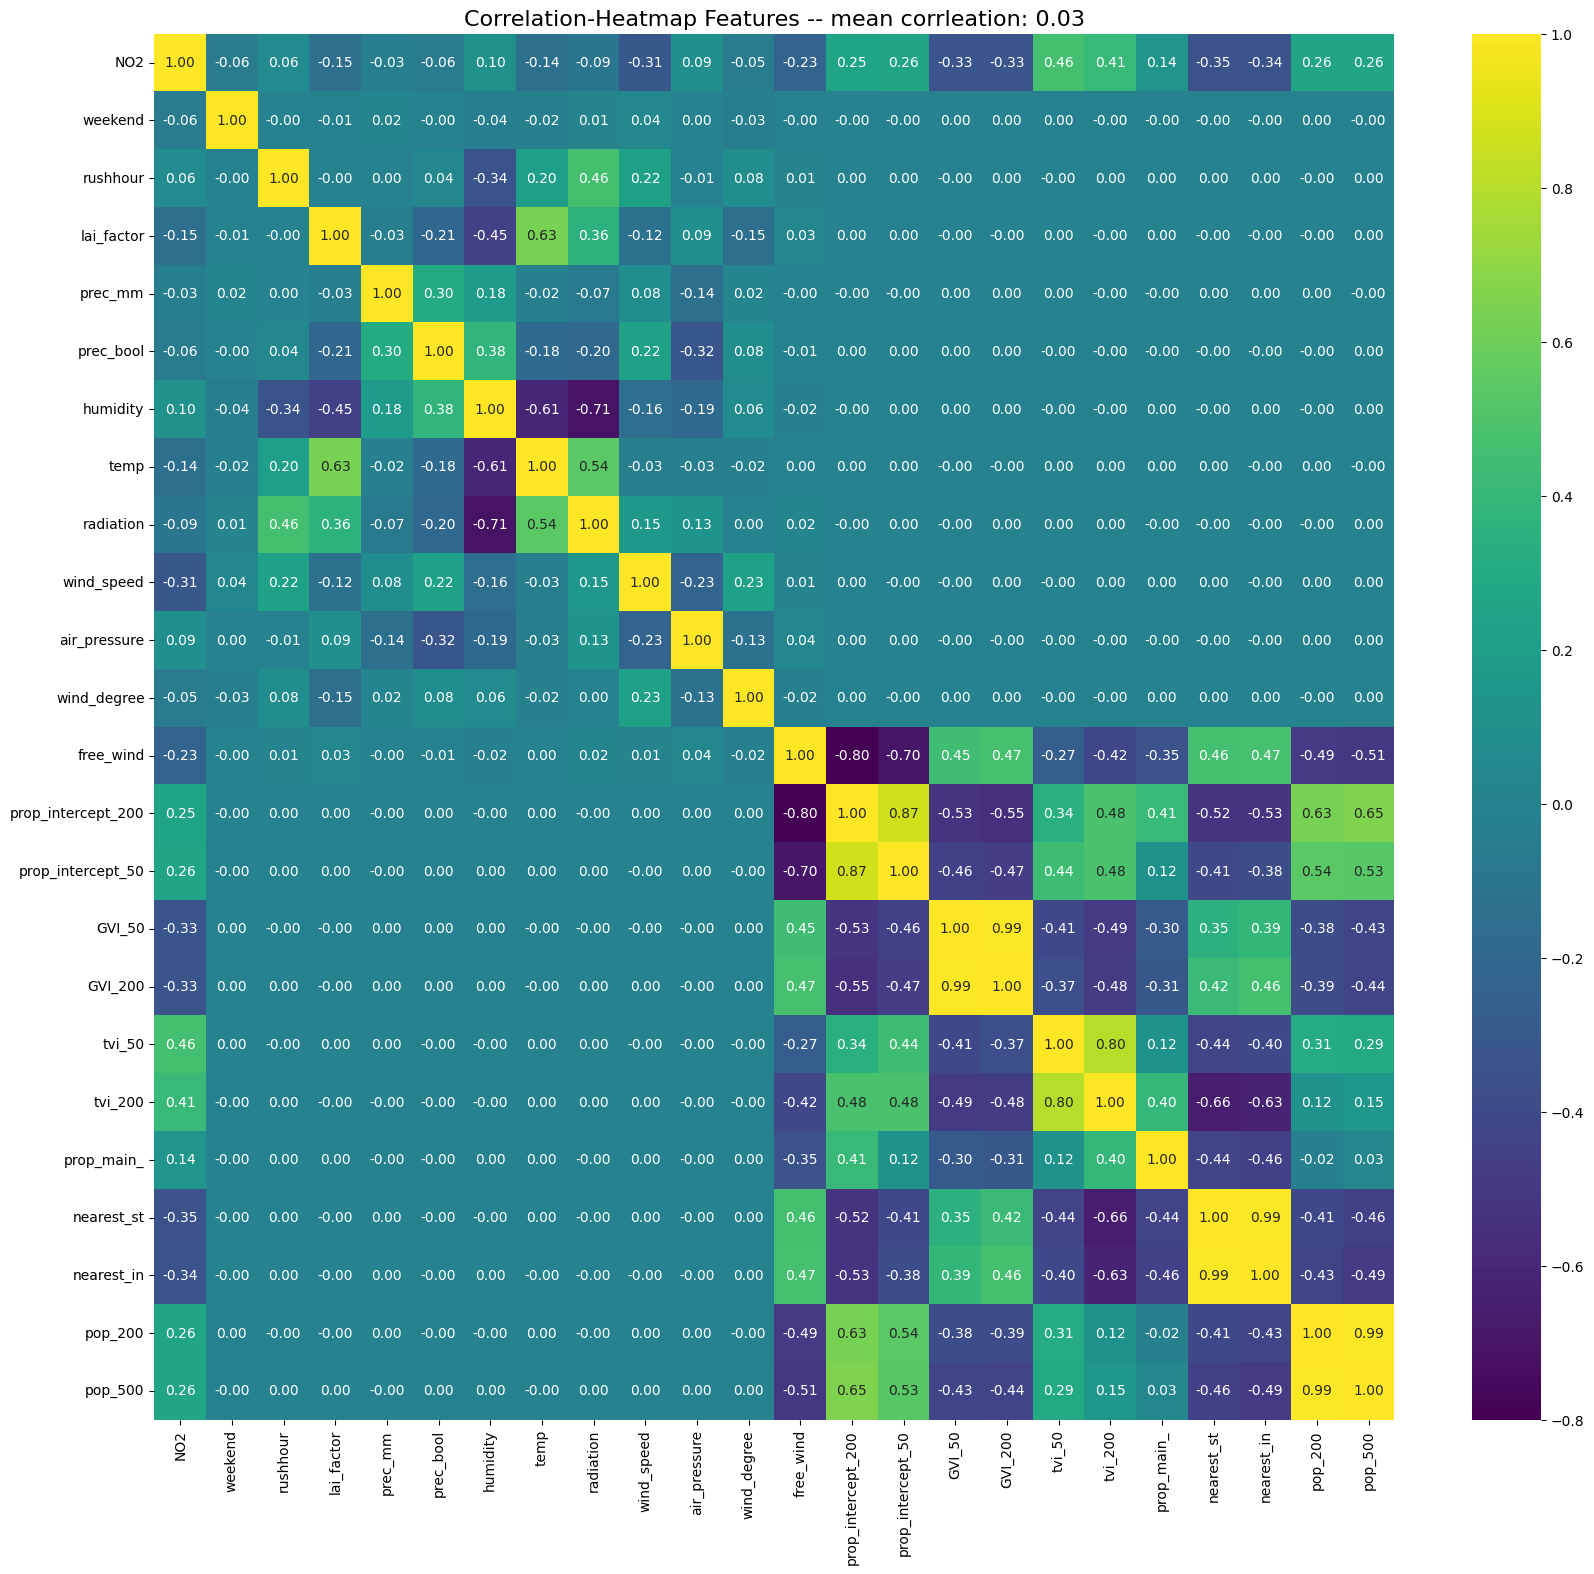

In [21]:
# metrological features
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr


def feature_correlation(df, features, name):

    df_no_na = df.dropna() # remove rows with na for correlation test
    
    # initialize and fill heatmap
    matrix = np.zeros((len(features), len(features))) 

    for i, feature1 in enumerate(features):
        for j, feature2 in enumerate(features):
            matrix[i, j] = round(pearsonr(df_no_na[feature1], df_no_na[feature2])[0],2) # correlation test 

    # Create a heatmap using seaborn
    plt.figure(figsize=(20, 18))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap='viridis',
                xticklabels=features, yticklabels=features)
    plt.title(f'{name} -- mean corrleation: {round(matrix.mean(),2)}', size = 16)
    plt.savefig(f"data/output/imputation/{name.replace(' ','_')}.png", dpi = 180)
    plt.show()


loc_feature =['prop_intercept_200', 'prop_intercept_50', 'GVI_50', 'GVI_200', 'tvi_50', 'tvi_200', 'prop_main_', 'nearest_st', 'nearest_in', 'pop_200','pop_500'] 
temp_feature =['weekend', 'rushhour', 'lai_factor', 'prec_mm', 'prec_bool', 'humidity',  'temp', 'radiation', 'wind_speed', 'air_pressure', 'wind_degree', 'free_wind']
features = ['NO2'] +  temp_feature + loc_feature


feature_correlation(df = main_train,
                    features = features,
                    name = 'Correlation-Heatmap Features')


In [23]:
# initial VIF analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = main_train.copy()
X = X.drop(['MESS_DATUM', 'id', 'NO2' ], axis = 1).astype(float) # exclude boolean
features = ['weighted_mean_pollution','nearest_in', 'prop_intercept_200', 'pop_500','GVI_25',
            'prop_main_','tvi_200', 'free_wind','lai_factor','wind_speed','temp','wind_degree',
            'rushhour', 'weekend', 'prec_mm', 'prec_bool']


def calculate_vifs(df):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

vif = calculate_vifs(X[features])
vif

,feature,VIF
0,weighted_mean_pollution,4.765154
1,nearest_in,3.257055
2,prop_intercept_200,11.400175
3,pop_500,6.075207
4,GVI_25,2.239136
5,prop_main_,3.346590
6,tvi_200,5.796384
7,free_wind,4.717863
8,lai_factor,16.115175
9,wind_speed,6.253640


In [24]:
new = pd.merge(left=mi, right= vif, on= 'feature', how = 'inner')[['feature', 'Mutual Information', 'VIF']]
new

,feature,Mutual Information,VIF
0,prec_mm,0.0023,1.136932
1,weekend,0.0023,1.034851
2,prec_bool,0.0028,1.571808
3,rushhour,0.0093,3.201559
4,wind_degree,0.0353,5.469958
5,temp,0.0431,5.816183
6,wind_speed,0.0640,6.253640
7,lai_factor,0.0686,16.115175
8,free_wind,0.0784,4.717863
9,prop_intercept_200,0.2437,11.400175


#### results: 


#### Representative Data split through station clustering:

The division into training, validation and test instances follows a location wise split approach, wherein the allocation of the sites to each set is determined in consideration of stratified sampling and expressiveness as the test results. To counteract the potential of spatial data leakage by including observations from the same site both in the training and test data, three independent monitoring stations are used for each the test and validation data. This approach stands in accordance with previous literature (source). Under the aspiration to allocate the monitoring stations with similar characteristics stratified between the sets a unsupervised clustering of the monitoring sites is performed. After grouping the monitoring sites in three clusters based on their land use characterizes, while excluding the target value, at least one example of each group is present in each dataset. This approach further moderates the risk of a selection bias wherein the examples in the test set are limited in their generalizability. For clustering k-nearest neighbor is utilized and achieved a silhouette score of differentiation of 0.35 (source and fig.). 

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Assuming 'id' is the column with station identifiers
location_features = ['prop_intercept_200', 'prop_intercept_50', 'GVI_50', 'GVI_200', 'tvi_50', 'tvi_200', 'prop_main_', 'nearest_st', 'nearest_in', 'pop_200','pop_500'] 

data = pd.read_csv('../datasets/df_2023_imputed.csv')
features_data = data[location_features]  # Select only location features for clustering
station_ids = data['id']  # Keep station ids for labeling in plots

# Scale the data to normalize it
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_data)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Measure the silhouette score to evaluate the quality of clustering
silhouette_avg = silhouette_score(X_scaled, clusters)
print("The average silhouette_score is :", silhouette_avg)

# Reduce dimensions to 2D for visualization, using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

c:\Users\richa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette_score is : 0.35846311341471226


c:\Users\richa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette_score is : 0.24503786577889167


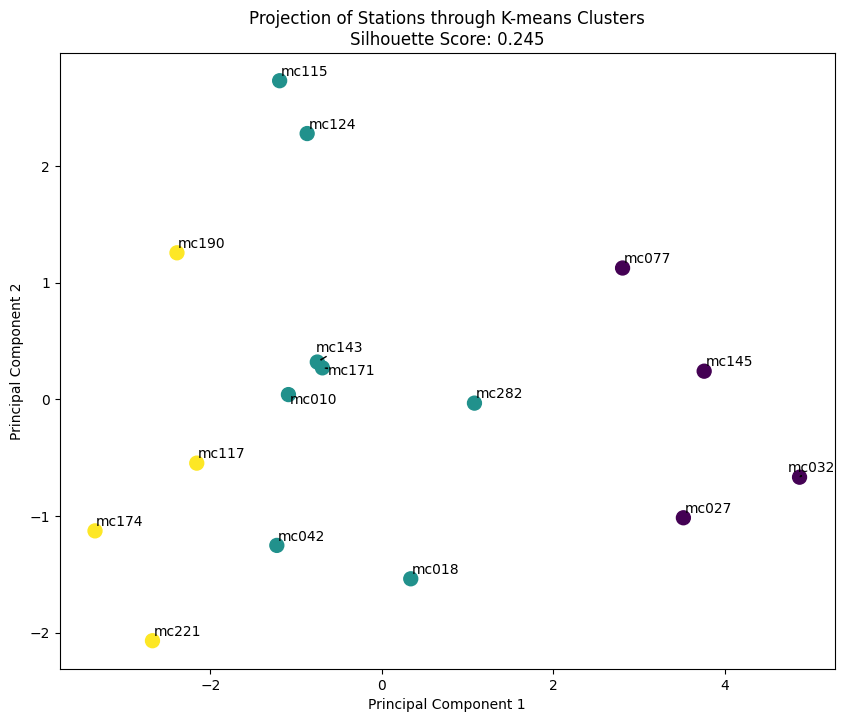

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from adjustText import adjust_text

# Assuming 'id' is the column with station identifiers
location_features = ['prop_intercept_200', 'prop_intercept_50', 'GVI_50', 'GVI_200', 'tvi_50', 'tvi_200', 'prop_main_', 'nearest_st', 'nearest_in', 'pop_200', 'pop_500']

data = pd.read_csv('../datasets/df_2023_imputed.csv')
# Group by station id and calculate mean of features
station_features = data.groupby('id')[location_features].mean().reset_index()

# Keep station ids for labeling in plots
station_ids = station_features['id'].values

# Scale the data to normalize it
scaler = StandardScaler()
X_scaled = scaler.fit_transform(station_features[location_features])

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Measure the silhouette score to evaluate the quality of clustering
silhouette_avg = silhouette_score(X_scaled, clusters)
print("The average silhouette_score is :", silhouette_avg)

# Reduce dimensions to 2D for visualization, using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plotting the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=100)

# Annotate the station ids
texts = []
for i, txt in enumerate(station_ids):
    texts.append(plt.text(X_pca[i, 0], X_pca[i, 1], txt))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

plt.title(f'Projection of Stations through K-means Clusters\nSilhouette Score: {round(silhouette_avg, 3)}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('data/output/cluster/clusterknn.png', dpi=300)
plt.show()
